# Thomas Hill, Summer 2020
# DATA 604 Final Project:
## Simulation of vancomycin dosing regimen using a one-compartment model


### Instructions
Using SimPy, write a process simulation that includes waiting time (discrete event simulation).  You may use any topic of interest to you.  Write the simulation and all of the following in Jupyter.

Each element is worth 5 points and will be graded using the rubric shown here.

1.  State the problem and its significance.

2.  Provide a flow-chart model. 

3.  Simulate the process for the appropriate number of iterations (justify)

4.  Justify the validity of the model and discuss how you verified it.

5.  State  your conclusions/ findings from the model. 

6.  Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues.  Post this to the discussion. 

Be sure that your code works!


### Introduction

Vancomycin is an essential antibiotic for the management of serious infections. It is a common adjuvant to broad spectrum or empiric antimicrobial therapy, and has excellent Gram positive bacterial coverage,including methicillin-resistant Staphylococcus aureus (MRSA). Typically, vancomycin and other antibiotics will be started as soon as an initial microbiology sample is collected, and once bacterial culture and susceptibilities are identified a more specific drug can be selected for the infection.

A common feature of vancomycin therapy is monitoring of drug concentrations, owing to the drug’s narrow therapeutic index. Like many antibiotics, vancomycin must achieve an adequate tissue concentration toinhibit and kill bacteria. However, high vancomycin levels are associated with nephrotoxicity and reversible kidney injury, as well as ototoxicity and worsening of existing hearing impairment. Vancomycin blood concentrations are taken 30 minutes prior to the next dose for a trough level, and dose and sometimes frequency of administration are adjusted.

### Modeling Approach/ Justification

Vancomycin is a straightforward medication to model, as its therapeutic and toxic concentrations are well defined, it diffuses predictably into most body tissues from the bloodstream, and clearance from the body is as unchanged drug via glomerular filtration in the kidneys. For this model I will simulate recurrent intermittent infusions overlying first-order elimination. Similar to the SIRS model studied in class, pharmacokinetics often use a 'compartment' scheme of modeling. Depending on the route of administration and site of action, drugs may be modeled by a 1-, 2-, or 3-compartment model. Vancomycin is ideally modeled during a two-compartment model as this ensures considerations for protein binding in the bloodstream and dissipation throughout the whole body, but for my purposes I am primarily interested in measurable concentrations in the bloodstream. 

A one-compartment model is primarily dependent on the current drug concentration and the elimination constant, k_e (units min^-1), which is the ratio of drug clearance (mL/min) to apparent volume of distribution (L) within the body. I will derive these latter two from randomly generated patient demographics to obtain a personal ke.  Additionally, I will base vancomycin dosing on generally accepted standards of therapy. 

### Goals
 
The purpose of the simulation is to explore practical issues related to vancomycin dosing, and validate the common dosing conventions and standard procedures are valid for the majority of patients. Primarily, I am interested in the most common  regimen in patients with stable renal function: three doses given equal intervals apart, then an initial trough concentration taken prior to the fourth dose.  The fourth dose is significant as this is expected to be the earliest that vancomycin is at steady state, or reaching a stable dose-to-dose concentration. To measure the success, I will look at the final trough concentration at 72 hours and see if it therapeutic. Additionally, I will look at the trough prior to 4th dose and see if it also is therapeutic, and potentially model a dose change if the trough level isn't within the target range. 
 

### Flow Chart

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/hillt5/DATA604/95db73a4c43d3ce441346099469df00e53763319/Flowchart.PNG")

### Simulation

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from modsim import *
from math import floor

# set the random number generator
np.random.seed(11206)

My first task in the simulation was defining a function to generate simulated patients. I modeled characteristics such as gender, age, weight and height randomly based on the expected distributions of each. 

In [3]:
#define three functions to better assign values based on patient characteristics

def get_age(turn, end, size): #I Googled 'trapezoidal distribution' to better model age
    pass
    totarea = turn + (end-turn)/2  # rectangle + triangle
    areauptoturn = turn             # rectangle
    areasloped = (end-turn)/2     # triangle
    size1= int(size*areauptoturn/totarea)
    size2= size- size1 
    s1 = np.random.uniform(low=0,high=turn,size= size1)  # (low=0.0, high=1.0, size=None)
    s2 = np.random.triangular(left=turn,mode=turn,right=end,size=size2) #(left, mode, right, size=None)
            # mode : scalar-  the value where the peak of the distribution occurs. 
            #The value should fulfill the condition left <= mode <= right.
    s3= np.concatenate((s1,s2)) # don't use add , it will add the numbers piecewise
    return s3


age_dist = 20 + get_age(40,60, 4000)

def get_weight(gender):
    if gender == 0:
        np.random.normal(77.3,7)
    else:
        np.random.normal(89.7,7)

        
def CrCl_wt(weight): #the Crockoft-Gault equation works best when it does not overestimate body weight > 72kg
    if weight <= 72:
        return weight
    else:
        return 72
    

def get_CrCl(params): #the Crockoft-Gault equation works best when it does not overestimate body weight > 72kg
    CrCl = (140 - params.age) * (CrCl_wt(params.weight))/(72 * params.scr)
    if params.gender == 0:
         return 0.85 * CrCl
    else:
        return CrCl

    
def get_tau(params): #dosing frequency is based on stepwise cutoffs of renal function
    if get_CrCl(params) < 40:
        return 24
    elif get_CrCl(params) > 60:
        return 8
    else:
        return 12
            #If CrCl >60ml/min then q8h; if CrCl 40 - 60ml/min, then q12h; if CrCl <40, then q24h

I organized all of these parameters into a function _get_patient_, which feeds values into another function that standardizes the vancomycin dosing. This second function, _get_vanco_dosing_, also has an optional argument for loading dose versus none. 

In [4]:
#define inital parameter of concentration where initial concentration is zero

def get_patient():
    gender = np.random.randint(0,2)
    age = int(np.random.choice(age_dist))
    scr = np.random.uniform(0.6,1.2)
    params = Params(gender = gender, age = age, 
                    weight = np.random.normal(77.3+(89.7-77.3)*gender, 12),  #normally distributed, dependent on gender
                    height = np.random.normal(1.615+(1.753-1.615)*gender, 0.0711+(0.0742-0.0711)*gender), #normally distributed, dependent on gender
                 scr = scr
                   )

    return params 


def get_vanco_dosing(params, loading = False):
    
    V = np.random.uniform(0.7,0.9)*params.weight, #volume of drug distribution, liters
    CL = 3.66 + 0.06 * (0.689 * get_CrCl(params)),
    wt = params.weight
    Dose = 250*round(17.5 * params.weight/250, 0), #rounds dose to the nearest 250mg
    T_infuse = float(0.5*round(250*round(17.5 * params.weight/250, 0)/500, 0)), #infuse 500mg over 30 minutes, or 1/2 hour
    Tau = get_tau(params) #dosing frequency in hours, based on renal function CrCl 
    if loading == False:
        loading_dose = 0
    else:
        loading_dose = 1
        
    return Params(C_0 = loading_dose*7.5*params.weight/V[0], CL = CL[0], V = V[0], Dose = Dose[0], T_infuse = T_infuse[0], Tau = Tau)
'''if loading dose is wanted, let C_0 = 25*params.weight/V[0]'''

'if loading dose is wanted, let C_0 = 25*params.weight/V[0]'

In order to verify my parameters were forming accurate distributions, I generated an array, _test_param_, which could be visualized as a histogram. This was helpful in making sure my age function was acting as planned, and that height and weight conformed to approximately a bimodal distribution because of their dependence on gender.

In [5]:
'''test_param = []
for i in range(4000):
    age = int(np.random.choice(age_dist)) #randomly select age between 20 and 79 years
    gender = np.random.randint(0,2) #0 for female, 1 for male
    height = np.random.normal(1.615+(1.753-1.615)*gender, 0.0711+(0.0742-0.0711)*gender)
    weight = np.random.normal(77.3+(89.7-77.3)*gender, 7)  #normally distributed, dependent on gender
    scr = np.random.uniform(0.6,1.2) #uniform distribution of renal function
    CrCl = (0.85+0.15*gender)*(140-age)*(CrCl_wt(weight))/(72 * scr) #Crockoft-Gault formula for renal function, mL/min
    V = np.random.uniform(0.7,0.9)*weight #volume of drug distribution, liters
    CL = 3.66 + 0.06 * (0.689 * CrCl)
    k = CL/V
    test_param.append(weight)

test_param = np.asarray(test_param)    
plt.hist(test_param)'''

#above is some code I used to verify that my parameters were generating suitable distributions of numbers

'test_param = []\nfor i in range(4000):\n    age = int(np.random.choice(age_dist)) #randomly select age between 20 and 79 years\n    gender = np.random.randint(0,2) #0 for female, 1 for male\n    height = np.random.normal(1.615+(1.753-1.615)*gender, 0.0711+(0.0742-0.0711)*gender)\n    weight = np.random.normal(77.3+(89.7-77.3)*gender, 7)  #normally distributed, dependent on gender\n    scr = np.random.uniform(0.6,1.2) #uniform distribution of renal function\n    CrCl = (0.85+0.15*gender)*(140-age)*(CrCl_wt(weight))/(72 * scr) #Crockoft-Gault formula for renal function, mL/min\n    V = np.random.uniform(0.7,0.9)*weight #volume of drug distribution, liters\n    CL = 3.66 + 0.06 * (0.689 * CrCl)\n    k = CL/V\n    test_param.append(weight)\n\ntest_param = np.asarray(test_param)    \nplt.hist(test_param)'

In the next few lines of code, I used the typical ModSimPy framework for making a system based on a handful of parameters and then defining an update function, all fed into a final _run_simulation_ function.

In [6]:
#define system to model vanco dose over time

def make_system(params):
    
    
    """Makes a System object with the given parameters.
    params: sequence of C_0, CL, V, Dose, T_infuse, Tau
    
    C_0 = initial concentration, 
    V = apparent volume of distribution, L
    CL = drug clearance, L/hr
    Dose = recommended vancomycin dose, mg
    T_infuse = infusion rate based on vanco dose, hours
    Tau = frequency of dosing interval
    
    returns: System object
    """
    C_0, CL, V, Dose, T_infuse, Tau = params
    
    t_0 = 0
    t_end = 72
    
    init = State(Conc = C_0)

    return System(params, init = init, t_0 = t_0, t_end = t_end, dt = 0.5)

In many of the examples in the textbook, the update function was simply an interpretation of the first derivative of the function being modeled. In this case, the second term, CL/V * Conc, is the derivative of exponential decay, with CL/V often referred to as k_e, or the elimination constant. In addition to this, the first term of my update function also calls an infusion function, which checks whether an infusion is due. Starting at t = 0, the first infusion will start and will continue until t > t_infuse. The dose is repeated at the beginning of each following interval, which repeats according to the dosing interval Tau. I was very happy with the use of modular math to solve this problem.          

In [7]:
#create dosing function for simulation of intravenous infusion

# infusion function
def infusion(system, t):
    if t % system.Tau < system.T_infuse: #this checks whether a repeat dose is due 
        return system.Dose/system.T_infuse #intermittent dose administration
    else:
        return 0 #dose is 0 when between doses

#create update function for system
def update_func(state, t, system):
    """Updates the vancomycin one-compartment model.
    
    state: State object
    t: time in hours
    system: System object
    
    returns: State object
    """
    Conc = state
    V, CL, T_infuse, Tau, dt = system.V, system.CL, system.T_infuse, system.Tau, system.dt 
        
    dcdt =  infusion(system, t) /V - (CL/V)*Conc
    
    Conc += dcdt * dt

    return State(Conc = Conc)

In [8]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

Finally, I executed my first test of my concentration function.

In [9]:
params = get_patient()
test_vanco = get_vanco_dosing(params)
test_system = make_system(test_vanco)
test_results = run_simulation(test_system, update_func)

I defined two functions that would obtain the trough right before the fourth dose and just prior to completion of therapy. These are the most clinically meaningful endpoints for drug monitoring. I used these functions to create two nested arrays of troughs to investigate the troughs my simulation was generating. I opted for running the simulation sixty times, 30 for loading and  non-loading dose, as this was the bare minimum I felt necessary to do. This proved to be one of the most computationally demanding steps.

In [10]:
def get_first_trough(results, system): 
    return float(results.row[system.Tau*3-0.5]) #before 4th dose

def get_final_trough(results, system): 
    return float(results.row[71.5]) #get final concentration

In [11]:
def get_n_troughs(n):
    first_trough_array = []
    final_trough_array = []
    for i in range(n):
        sim_params = get_patient()
        sim_vanco = get_vanco_dosing(sim_params)
        sim_system = make_system(sim_vanco)
        sim_results = run_simulation(sim_system, update_func)
        first_trough_i = get_first_trough(sim_results, sim_system)
        final_trough_i = get_final_trough(sim_results, sim_system)
        first_trough_array.append(first_trough_i)
        final_trough_array.append(final_trough_i)
        i += 1
    return [first_trough_array, final_trough_array]
                    
                                          

In [12]:
test_troughs = get_n_troughs(30)

(array([4., 1., 5., 4., 3., 4., 0., 2., 4., 3.]),
 array([ 9.93309197, 11.24753821, 12.56198446, 13.8764307 , 15.19087695,
        16.50532319, 17.81976943, 19.13421568, 20.44866192, 21.76310817,
        23.07755441]),
 <a list of 10 Patch objects>)

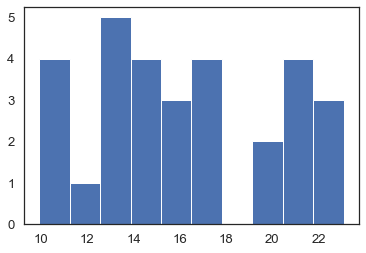

In [13]:
plt.hist(test_troughs[0])

In [14]:
np.mean(test_troughs,axis = 1)

array([16.14718929, 17.43721514])

In [15]:
def get_n_loading_troughs(n):
    first_trough_array = []
    final_trough_array = []
    for i in range(n):
        sim_params = get_patient()
        sim_vanco = get_vanco_dosing(sim_params, loading = True)
        sim_system = make_system(sim_vanco)
        sim_results = run_simulation(sim_system, update_func)
        first_trough_i = get_first_trough(sim_results, sim_system)
        final_trough_i = get_final_trough(sim_results, sim_system)
        first_trough_array.append(first_trough_i)
        final_trough_array.append(final_trough_i)
        i += 1
    return [first_trough_array, final_trough_array]
                    

In [16]:
test_loading_troughs = get_n_loading_troughs(30)
np.mean(test_loading_troughs, axis = 1)


array([14.70620169, 15.15930499])

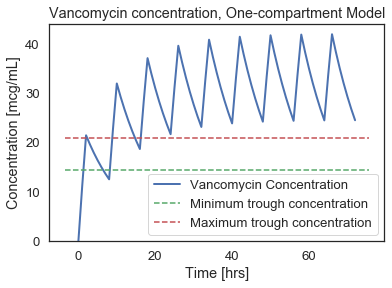

In [17]:

def plot_concentration(results):
    plot(results.Conc)
    plt.plot(plt.xlim(),[14.5,14.5],'g--',plt.xlim(),[21,21],'r--')
    plt.legend(['Vancomycin Concentration','Minimum trough concentration','Maximum trough concentration'])
    plt.xlabel('Time [hrs]')
    plt.ylabel('Concentration [mcg/mL]')
    plt.ylim(bottom = 0)
    plt.title('Vancomycin concentration, One-compartment Model');

plot_concentration(test_results)

In [18]:
loading_test_vanco = get_vanco_dosing(params, loading = True)
loading_test_system = make_system(loading_test_vanco)
loading_test_results = run_simulation(loading_test_system, update_func)

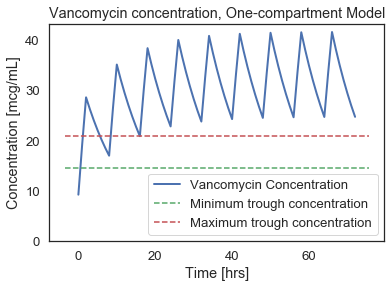

In [19]:
plot_concentration(loading_test_results)

Finally, to see the impact on the initial trough concentration, I swept a modified system function for values of CL and V. As I mentioned above, these are the two most important parameters because their ratio is the constant of elimination, k_e. For the rest of the system, I used the most common vancomycin dosing regimen, 1 gram every 8 hours, with no loading dose. I swept over values of CL and V that considered dosing for what encompassed 95% of variation in weight, as well as full variation in age and serum creatinine.

In [20]:
#define system to sweep with - only looking at variables CL and V

def make_sweep_system(CL, V, loading = False):
    
    
    """Makes a System object with the given parameters.
    params: sequence of C_0, CL, V, Dose, T_infuse, Tau
    
    C_0 = initial concentration, 
    V = apparent volume of distribution, L
    CL = drug clearance, L/hr
    Dose = recommended vancomycin dose, mg
    T_infuse = infusion rate based on vanco dose, hours
    Tau = frequency of dosing interval
    
    returns: System object
    """
    CL = CL
    V = V
    C_0 = 500/V
    Dose = 1000
    T_infuse = 2
    Tau = 8
    
    if loading == False:
        loading = 0
    else:
        loading = 1
        
    t_0 = 0
    t_end = 72
    
    init = State(Conc = C_0)

    return System(CL = CL, V = V, C_0 = C_0*loading, Dose = Dose, T_infuse = T_infuse, Tau = Tau, init = init, t_0 = t_0, t_end = t_end, dt = 0.5)


def get_first_trough_sweep(results): 
    return float(results.row[23.5]) #for sweeping parameter I chose q8h dosing for Tau

In [21]:
CL_array = linspace(4.7, 8.7, 9)
V_array = linspace(35, 105, 8)

def sweep_CL(CL_array, V):
    sweep = SweepSeries()
    for CL in CL_array:
        system = make_sweep_system(CL, V)
        results = run_simulation(system, update_func)
        sweep[system.CL] = get_first_trough_sweep(results)
    return sweep

def sweep_parameters(CL_array, V_array):
    frame = SweepFrame(columns=V_array)
    for V in V_array:
        frame[V] = sweep_CL(CL_array, V)
    return frame

In [22]:
trough_sweep = sweep_parameters(CL_array, V_array)

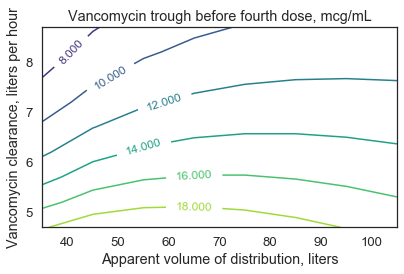

In [23]:
contour(trough_sweep)

decorate(xlabel='Apparent volume of distribution, liters',
         ylabel='Vancomycin clearance, liters per hour',
         title='Vancomycin trough before fourth dose, mcg/mL')

My interpretation of the sweep contour plot is that vancomycin elimination is much more sensitive to changes in clearance. This is what I would expect as renal function is an important contributor to vancomycin dosing. It also means that I would expect little variation apart from clearance, as volume of distribution had minimal impact initial trough.

### Model Validation

For verification, I implemented a function, get_patient,to simulate a patient representative of an average American. I randomized gender, simulated weight and height with parameters based on gender-specificCDC statistics, and age based on a trapezoidal distribution that approximated picking a random member of the US population between the ages of 20 and 80. I assignedserum creatinine based on a uniform distribution between the levels generally accepted as within normal range, 0.6 – 1.2 mg/dL. Almost all other values beingsimulated are based on these values. The only exception is vancomycin’s volume of distribution, which is reported in drug monographs as usually being between0.7 – 0.9 L/kg. I modeled this as a uniform distribution. All of the demographics were then tested using some codethat generated several thousand values, added them to array test_param,and plotted a histogram. I tinkered with some of the values to obtain anacceptable trapezoidal distribution for age and bimodal distributions of weight and height with both genders aggregated together.For validation purposes, I was more limited in my options asreal-life drug monitoring is subject to patient privacy, and real-timemonitoring of drug concentrations is rare outside of academic and industry research.Instead, I generated a few dozen patients and looked at their consequent vancomycin doses and trough levels.  I compared to these to typical dosing regimens and trough concentrations and theyall fell within my expectations. 

### Conclusions and future directions

Based on the simulated troughs, I believe my one-compartment model simulates real life troughs based on patient demographics and offer a good approximation to physiological drug metabolism. Both standard and loading dose regimens provided some variability in both initial and final troughs. In general though, the initial troughs were rarely supratherapeutic and correlated well to steady state achieved by 72 hours after initial dose. Loading doses achieved steady state concentrations sometimes afer one dose; however, they also generated more supratherapeutic troughs that would require clinical dose adjustment. 

I also looked at two important parameters, drug clearance and volume of distribution, to measure the consequent impact on initial trough. The findings confirmed that vancomycin clearance had a more prominent impact than interpersonal variability of the volume of distribution.

In the future, I would like to look into several different models that have been used for measuring efficacy of vancomycin antimicrobial activity. These include two- and three-compartment models, calculation of area under curve (AUC) concentrations, and calculation of parameters on the basis of the first dose. This final framework could be generalized to patients not considered in my simulation - those with little to no renal function at time of hospitalization.

### Sources and further reading

Inspiration for simulating vancomycin pharmacokinetics: a Github repository for vancomycin Shiny app. This is based on a two-compartment model  https://github.com/asancpt/shiny-vtdm

Code basis for one-compartment pharmacokinetics: https://jckantor.github.io/CBE30338/03.05-One-Compartment-Pharmacokinetics.html

Additional reading on alternative vancomycin dosing regimens: https://emcrit.org/pulmcrit/vanco/
